# Imports:

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import warnings
from tables import NaturalNameWarning
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay
warnings.filterwarnings('ignore', category=NaturalNameWarning)

# Data Aquisition:

In [136]:
hdf = pd.HDFStore('data.h5')

temp = pd.DataFrame({'col1': [1, 2], 'col2': [3, 4]})

hdf.put('Mason', temp)
hdf.put('Amy', temp)
hdf.put('Carter', temp)

# display hf structure 
def h5_tree(val, pre=''):
    items = len(val)
    for key, val in val.items():
        items -= 1
        if items == 0:
            # the last item
            if type(val) == h5py._hl.group.Group:
                print(pre + '└── ' + key)
                h5_tree(val, pre+'    ')
            else:
                print(pre + '└── ' + key + ' (%d)' % len(val))
        else:
            if type(val) == h5py._hl.group.Group:
                print(pre + '├── ' + key)
                h5_tree(val, pre+'│   ')
            else:
                print(pre + '├── ' + key + ' (%d)' % len(val))



jumping_df = pd.DataFrame
jumping_files = ['mason-jumping-1.csv', 'Carter_jumping.csv', 'Amy_Jumping.csv', 'mason-jumping-2.csv']
for file in jumping_files:
    temp = pd.read_csv(file)
    if 'Mason' or 'mason' in file:
        hdf.put('Mason', temp)
    elif 'Amy' or 'amy' in file:
        hdf.put('Amy', temp)
    elif 'Carter' or 'carter' in file:
        hdf.put('Carter', temp)
    

    if jumping_df.empty:
        jumping_df = temp
        # delete first and last 2 seconds of data
        jumping_df = jumping_df.drop(jumping_df.index[0:200])
        jumping_df = jumping_df.drop(jumping_df.index[-200:])
    else:
        # delete first and last 2 seconds of data
        temp = temp.drop(temp.index[0:200])
        temp = temp.drop(temp.index[-200:])
        jumping_df = pd.concat([jumping_df, temp])

walking_df = pd.DataFrame
walking_files = ['mason-walking-1.csv', 'Carter_walking.csv', 'Amy_Walking.csv']
for file in walking_files:
    temp = pd.read_csv(file)

    if 'Mason' or 'mason' in file:
        hdf.put('Mason', temp)
    elif 'Amy' or 'amy' in file:
        hdf.put('Amy', temp)
    elif 'Carter' or 'carter' in file:
        hdf.put('Carter', temp)

    if walking_df.empty:
        walking_df = temp
        # delete first and last 2 seconds of data
        walking_df = walking_df.drop(walking_df.index[0:200])
        walking_df = walking_df.drop(walking_df.index[-200:])
    else:
        # delete first and last 2 seconds of data
        temp = temp.drop(temp.index[0:200])
        temp = temp.drop(temp.index[-200:])
        walking_df = pd.concat([walking_df, temp])


# add labels
walking_df['class'] = 0
jumping_df['class'] = 1

# combine dataframes
df = pd.concat([walking_df, jumping_df], ignore_index=True)

# replace column names
df.columns = ['Time', 'Accel X', 'Accel Y', 'Accel Z', 'Absolute Accel', 'Class']

hdf.put('dataset', df, format='table', data_columns=True)

print(hdf.keys())
# close hdf file
hdf.close()


['/Amy', '/Connor', '/Mason', '/dataset']


# Visualization:

       Time   Accel X   Accel Y   Accel Z  Absolute Accel  Class
0  1.093852 -5.672278  0.300588  1.979976        6.015430      0
1  1.098800 -5.491416  0.280305  2.785333        6.163789      0
2  1.103748 -5.470981  0.436641  3.400820        6.456614      0
3  1.108697 -5.621639  0.595874  3.753166        6.785584      0
4  1.113645 -5.909056  0.762246  3.833645        7.084828      0


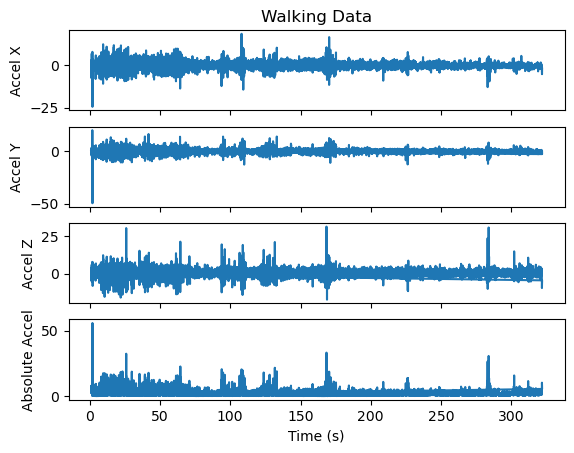

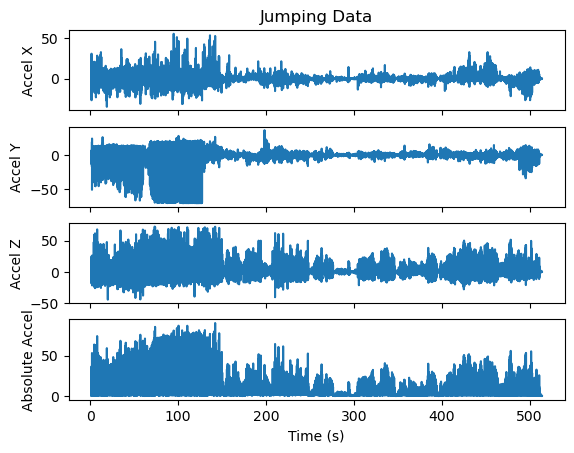

In [137]:
# array columns: Time, Accel X, Accel Y, Accel Z, Absolute Accel Class
# array rows: 1 row per 5 seconds of data
# walking class is 0
# jumping class is 1



df = pd.read_hdf('data.h5', 'dataset', mode='a')
print(df.head())


# plot walking data
walking_df = df[df['Class'] == 0]
walking_df = walking_df.reset_index(drop=True)
walking_df = walking_df.drop(['Class'], axis=1)
axis, fig = plt.subplots(4, sharex=True)
fig[0].plot(walking_df['Time'], walking_df['Accel X'])
fig[0].set_ylabel('Accel X') 
fig[0].set_title('Walking Data')
fig[1].plot(walking_df['Time'], walking_df['Accel Y'])
fig[1].set_ylabel('Accel Y')
fig[2].plot(walking_df['Time'], walking_df['Accel Z'])
fig[2].set_ylabel('Accel Z')
fig[3].plot(walking_df['Time'], walking_df['Absolute Accel'])
fig[3].set_ylabel('Absolute Accel')
fig[3].set_xlabel('Time (s)')


# plot jumping data
jumping_df = df[df['Class'] == 1]
jumping_df = jumping_df.reset_index(drop=True)
jumping_df = jumping_df.drop(['Class'], axis=1)
axis1, fig1 = plt.subplots(4, sharex=True)
fig1[0].plot(jumping_df['Time'], jumping_df['Accel X'])
fig1[0].set_ylabel('Accel X')
fig1[0].set_title('Jumping Data')
fig1[1].plot(jumping_df['Time'], jumping_df['Accel Y'])
fig1[1].set_ylabel('Accel Y')
fig1[2].plot(jumping_df['Time'], jumping_df['Accel Z'])
fig1[2].set_ylabel('Accel Z')
fig1[3].plot(jumping_df['Time'], jumping_df['Absolute Accel'])
fig1[3].set_ylabel('Absolute Accel')
fig1[3].set_xlabel('Time (s)')

plt.show()

# Preprocessing:

In [138]:
df = pd.read_hdf('data.h5', 'dataset', mode='a')
rows_per_chunk = int(round(5/(df['Time'][1]-df['Time'][0])))
print("Rows per chunk", rows_per_chunk)


# split data by class
walking_df = df[df['Class'] == 0]
walking_df = walking_df.reset_index(drop=True)
walking_df = walking_df.drop(['Class'], axis=1)

jumping_df = df[df['Class'] == 1]
jumping_df = jumping_df.reset_index(drop=True)
jumping_df = jumping_df.drop(['Class'], axis=1)


# remove outliers that are more than 3 standard deviations from the mean
walking_df = walking_df[(np.abs(walking_df['Absolute Accel']-walking_df['Absolute Accel'].mean()) <= (3*walking_df['Absolute Accel'].std()))]
jumping_df = jumping_df[(np.abs(jumping_df['Absolute Accel']-jumping_df['Absolute Accel'].mean()) <= (3*jumping_df['Absolute Accel'].std()))]


# split data into 5 second chunks and make each one into a dataframe
walking_chunks = [walking_df[i:i+rows_per_chunk] for i in range(0, walking_df.shape[0], rows_per_chunk)]
jumping_chunks = [jumping_df[i:i+rows_per_chunk] for i in range(0, jumping_df.shape[0], rows_per_chunk)]
# remove last chunk if it is not 5 seconds long
if len(walking_chunks[-1]) != rows_per_chunk:
    walking_chunks.pop()
if len(jumping_chunks[-1]) != rows_per_chunk:
    jumping_chunks.pop()

# convert list of dataframes into a numpy array
walking_chunks = np.array([chunk.values for chunk in walking_chunks])
jumping_chunks = np.array([chunk.values for chunk in jumping_chunks])
# set time column to 0 through 5 seconds
walking_chunks[:, :, 0] = np.linspace(0, 5, rows_per_chunk)
jumping_chunks[:, :, 0] = np.linspace(0, 5, rows_per_chunk)

print("Walking chunks shape", walking_chunks.shape)
print("Walking Chunks start: ", walking_chunks[0][0])
print("Jumping chunks shape", jumping_chunks.shape)
print("Jumping Chunks start: ", jumping_chunks[0][0])

data = {'walking': walking_chunks, 'jumping': jumping_chunks}



Rows per chunk 1010
Walking chunks shape (104, 1010, 5)
Walking Chunks start:  [ 0.         -5.6722784   0.30058789  1.9799757   6.01543009]
Jumping chunks shape (92, 1010, 5)
Jumping Chunks start:  [ 0.         -9.77982712  0.66529799 -3.41383529 10.37988012]


Feature Extraction:

In [139]:
# TODO find maximum, minimum, range, mean, median, variance, and standard deviation for each chunk
walking_features = []
for i in data['walking']:
    for j in range(1,5):
        walking_features.append([np.max(i[:, j]), np.min(i[:, j]), np.ptp(i[:, j]), np.mean(i[:, j]), np.median(i[:, j]), np.var(i[:, j]), np.std(i[:, j])])
walking_features = np.array(walking_features)
walking_features = walking_features.reshape(walking_chunks.shape[0], 4, 7)
print("Walking features shape", walking_features.shape)

jumping_features = []
for i in data['jumping']:
    for j in range(1,5):
        jumping_features.append([np.max(i[:, j]), np.min(i[:, j]), np.ptp(i[:, j]), np.mean(i[:, j]), np.median(i[:, j]), np.var(i[:, j]), np.std(i[:, j])])
jumping_features = np.array(jumping_features)
jumping_features = jumping_features.reshape(jumping_chunks.shape[0], 4, 7)
print("Jumping features shape", jumping_features.shape)

Walking features shape (104, 4, 7)
Jumping features shape (92, 4, 7)


In [140]:
# find the mean of each feature for each chunk
walking_x = np.mean(walking_features[:, 0, :], axis=0)
walking_y = np.mean(walking_features[:, 1, :], axis=0)
walking_z = np.mean(walking_features[:, 2, :], axis=0)
walking_abs = np.mean(walking_features[:, 3, :], axis=0)

jumping_x = np.mean(jumping_features[:, 0, :], axis=0)
jumping_y = np.mean(jumping_features[:, 1, :], axis=0)
jumping_z = np.mean(jumping_features[:, 2, :], axis=0)
jumping_abs = np.mean(jumping_features[:, 3, :], axis=0)

# print the mean of each feature
print("Mean of each feature: Max, Min, Range, Mean, Median, Variance, Standard Deviation")
print("Walking X Mean: ", walking_x)
print("Walking Y Mean: ", walking_y)
print("Walking Z Mean: ", walking_z)
print("Walking Absolute Mean: ", walking_abs)
print("Jumping X Mean: ", jumping_x)
print("Jumping Y Mean: ", jumping_y)
print("Jumping Z Mean: ", jumping_z)
print("Jumping Absolute Mean: ", jumping_abs)


Mean of each feature: Max, Min, Range, Mean, Median, Variance, Standard Deviation
Walking X Mean:  [ 4.20306468 -4.04510098  8.24816566 -0.01004766 -0.03809667  1.80008476
  1.27537365]
Walking Y Mean:  [ 3.74246486 -4.38111444  8.1235793  -0.14013675 -0.09833544  1.62300841
  1.18988133]
Walking Z Mean:  [ 5.0235205  -4.29605025  9.31957074  0.15828635  0.08672114  2.21601498
  1.42194111]
Walking Absolute Mean:  [6.14215421 0.16327657 5.97887765 1.99812944 1.79470022 1.33772103
 1.10012009]
Jumping X Mean:  [ 13.49298496 -11.92504943  25.41803439   0.02858995  -0.04696897
  11.03839254   3.09655397]
Jumping Y Mean:  [ 12.88491618 -17.46481886  30.34973504   0.3134392    1.55351771
  44.63961486   5.24294291]
Jumping Z Mean:  [ 28.39064545 -18.75293533  47.14358077  -0.64300791  -2.72596442
  87.75843648   8.49879565]
Jumping Absolute Mean:  [35.42244821  0.49967165 34.92277656  9.96303236  8.87649621 38.95545216
  6.08552166]


In [141]:
df = pd.DataFrame(data=((k, items) for k, v in data.items() for items in v), columns=['Class', 'Data'])
X_train, X_test, y_train, y_test = train_test_split(df['Data'], df['Class'], test_size=0.1, random_state=42, shuffle=True)

# flatten X_train and X_test
X_train = np.array([i.flatten() for i in X_train])
X_test = np.array([i.flatten() for i in X_test])

# save split in hdf5 file
with pd.HDFStore('data.h5', mode='a') as store:
    store.put('dataset/train/X_train', pd.DataFrame(X_train))
    store.put('dataset/test/X_test', pd.DataFrame(X_test))
    store.put('dataset/train/y_train', pd.DataFrame(y_train))
    store.put('dataset/test/y_test', pd.DataFrame(y_test))

In [166]:
scaler = StandardScaler()
lr = LogisticRegressionCV(cv=5, random_state=42, max_iter=1000)
clf = make_pipeline(scaler, lr)

clf.fit(X_train, y_train)

train_acc = cross_val_score(clf, X_train, y_train, cv=5)
print("Training Accuracy per fold:")
print(train_acc)

Training Accuracy per fold:
[0.91666667 0.94285714 0.97142857 0.91428571 0.97142857]


In [167]:
# get predictions and accuracy
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)
train_pred = clf.predict(X_train)
print('Training Accuracy: ', accuracy_score(y_train, train_pred))
print('Testing Accuracy: ', accuracy_score(y_test, y_pred))

Training Accuracy:  0.9886363636363636
Testing Accuracy:  1.0


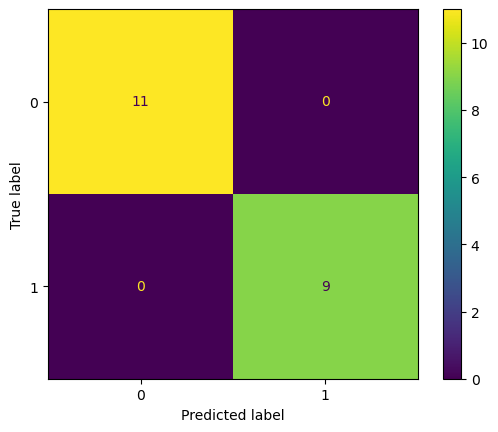

In [168]:
# get confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.show()

In [169]:
# get f1 score
try:
    f1 = f1_score(y_test, y_pred)
    print('F1 score: ', f1)
except:
    print('F1 score: N/A')

F1 score: N/A


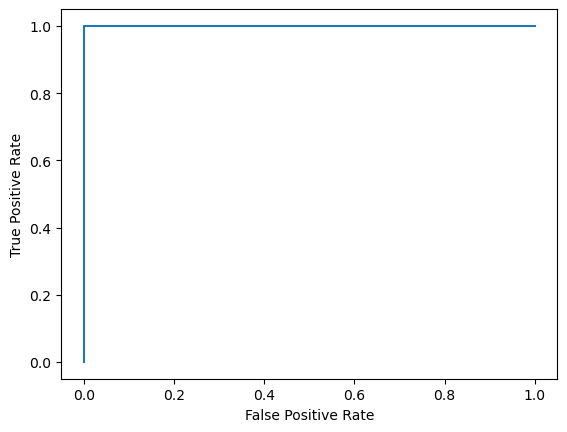

In [170]:
# plot the ROC curve
frp, twp, _ = roc_curve(y_test, y_pred_proba[:, 1], pos_label=clf.classes_[1])
roc_display = RocCurveDisplay(fpr=frp, tpr=twp).plot()
plt.show()

## Trying the model using PCA:

In [171]:
feats = {"Walking": walking_features, "Jumping": jumping_features}
data_feats = pd.DataFrame(data=((k, items) for k, v in feats.items() for items in v), columns=['Class', 'Data'])
X2_train, X2_test, y2_train, y2_test = train_test_split(data_feats['Data'], data_feats['Class'], test_size=0.1, random_state=42, shuffle=True)


# flatten X_train and X_test
X2_train = np.array([i.flatten() for i in X2_train])
X2_test = np.array([i.flatten() for i in X2_test])
print(X2_train.shape)

(176, 28)


In [172]:
scalar = StandardScaler()
lr = LogisticRegression(max_iter=1000)
pca = PCA(n_components=2)
pca_pipe = make_pipeline(scalar, pca)
X_train_pca = pca_pipe.fit_transform(X2_train)
X_test_pca = pca_pipe.transform(X2_test)
clf2 = make_pipeline(lr)
clf2.fit(X_train_pca, y2_train)
train_pred = clf2.predict(X_train_pca)
print('Training Accuracy: ', accuracy_score(y2_train, train_pred))


y_pred_pca = clf2.predict(X_test_pca)
print('Test Accuracy: ', accuracy_score(y2_test, y_pred_pca))

Training Accuracy:  0.9886363636363636
Test Accuracy:  1.0


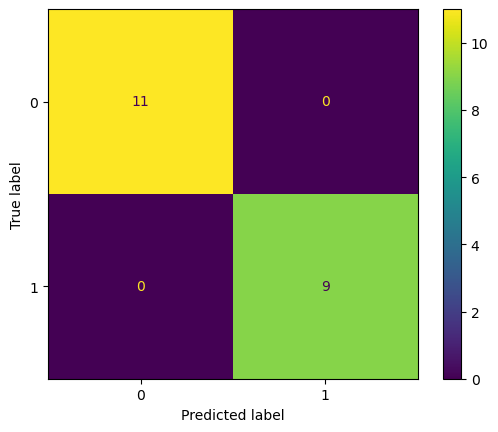

In [173]:
# get confusion matrix
cm = confusion_matrix(y2_test, y_pred_pca)
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.show()

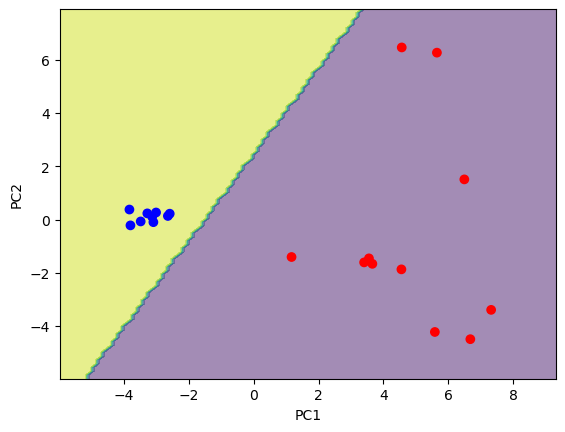

In [174]:
disp = DecisionBoundaryDisplay.from_estimator(clf2, X_train_pca, response_method='predict', xlabel='PC1', ylabel='PC2', alpha=0.5)
disp.ax_.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=['red' if i == 'Jumping' else 'blue' for i in y2_test])
plt.show()

In [175]:
# find the index of the largest magnitude in each component
print("Index of largest magnitude in each component")
print(np.argmax(np.abs(pca.components_[0])), np.argmax(np.abs(pca.components_[1])))

        

Index of largest magnitude in each component
24 11


## Dumping the pickle file:

In [176]:
import pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(clf, f)

with open('model_pca.pkl', 'wb') as f:
    pickle.dump(clf2, f)

with open('pca.pkl', 'wb') as f:
    pickle.dump(pca_pipe, f)